In [1]:
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.5.4.58-cp38-cp38-manylinux2014_x86_64.whl (47.6 MB)


In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil
from functools import reduce
import hashlib
import uuid
from collections import Counter
from datetime import datetime, timedelta

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

In [3]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [94]:
# ds

In [113]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

# constants for openCV countour finding
SMOOTH_RATIO = 0.005
MIN_AREA = 150
CONVEX = False

# constants derived from the root dataset
LONS = ds.coords['lon']
LATS = ds.coords['lat']


class Contour():
    """A single contour obj. All unit operations are managed here."""
    
    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.name = uuid.uuid4().hex[:6]
        self._area = 0.0
        self._smoothened = np.array([], dtype=np.int32)
        self._projected = np.array([], dtype=np.float64)
        self._center = ()
    
    def __repr__(self):
        return self.name
    
    @property
    def area(self):
        return cv2.contourArea(self.contour)
    
    @property
    def smoothened(self):
        cnt = self.contour
        arc = SMOOTH_RATIO*cv2.arcLength(cnt,True)
        return cv2.approxPolyDP(cnt,arc,True)
    
    @property
    def projected(self):
        squeezed = self.smoothened.squeeze()
        proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in squeezed]
        return np.array(proj).reshape((-1,1,2))
    
    @property
    def center(self):
        M = cv2.moments(self.contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (float(LONS[cX]), float(LATS[cY])) 

    def position_to(self, c2:object)->str:
        f = cv2.pointPolygonTest
        c1 = self.contour.squeeze().astype(float)
        tf = np.array([int((f(c2.contour, x, False))) for x in c1])
        if all(tf==-1):
            return "outside"  
        elif all(tf==1):
            return "inside" 
        else:
            return "intersect" 
    
    def __add__(self, obj2:object):
        """Fuse two countor objects ('bubbles'). Better do this if they 
        intersect or one is enclosed inside the other."""
        c1, c2 = self.contour, obj2.contour
        fused = cv2.convexHull(np.vstack([c1, c2]))
        new_obj = self.__class__(fused)
        new_obj.name = self.name
        return new_obj

def find_contours(arr2d: np.array, 
                  convex:bool=False, 
                  min_area:int=150) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),].
    input:  day-slice of a dataset tasmax dataarray
    output: list of contours (np.arrays)"""
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if convex:
        contours = [cv2.convexHull(c) for c in contours]
        
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    for c in contours:
        if c.ndim!=3:
            print(c.shape)
    contours = [Contour(c) for c in contours]
    contours = [c for c in contours if c.area>min_area]
    
    return contours

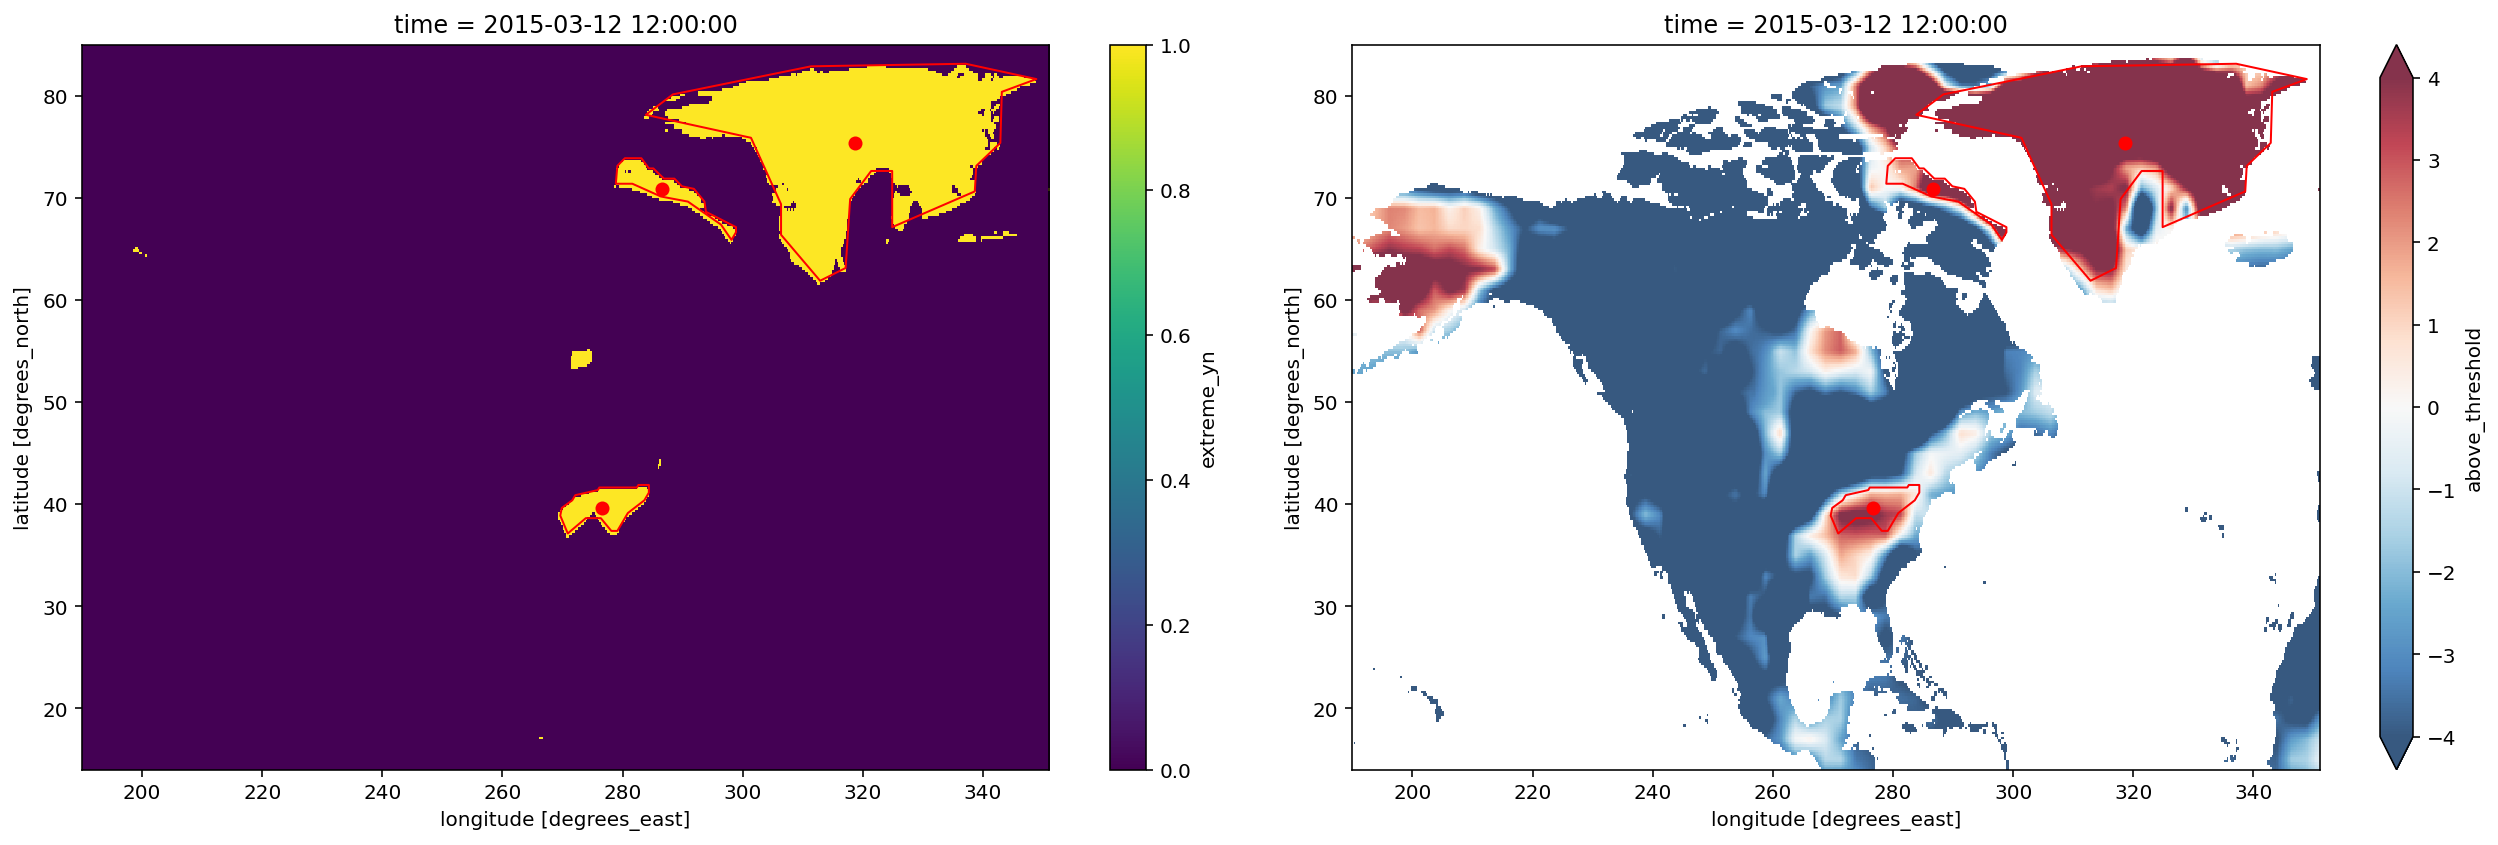

In [114]:
####################################
# Visualize a random day
####################################

# select the day to plot
idx = 70

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA) 

# add these patches on the plot(s)
patches = [Polygon(c.projected.squeeze(), True) for c in contours]

args = dict(edgecolors=("r",), linewidths=(1,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
[ax1.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]
p = PatchCollection(patches, **args)
ax2.add_collection(p)
[ax2.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]

fig.tight_layout()

In [115]:
%%time
####################################
# Rolling contours on time axis
####################################

def find_daily_contours(ds:xr.Dataset)->pd.DataFrame:
    """Give a dataset and it will loop through days and
    find all contours per day, if any."""
    
    dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

    all_contours = []
    days = []
    for d in dr:
        day = d.strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        arr2d = extreme.values[0]

        all_contours += [find_contours(arr2d, convex=CONVEX, min_area=MIN_AREA)]
        days += [day]

    df = pd.DataFrame(dict(days=days, contours=all_contours))

    assert len(ds['extreme_yn'])==len(df)
    
    return df
    
df_daily = find_daily_contours(ds)
df_daily

CPU times: user 2.11 s, sys: 798 ms, total: 2.91 s
Wall time: 1.45 s


days                                           contours
0    2015-01-01                   [077df0, efd098, 5b15ea, 6b1327]
1    2015-01-02           [2c4f65, e4fbca, 74b3aa, 2eb4fc, 925510]
2    2015-01-03   [5b731e, 11064c, 6b6d84, 1c92e8, ad8e66, 8dc625]
3    2015-01-04  [c02237, 87e577, 458809, 97b78d, 3bc5f4, d26ad...
4    2015-01-05   [25590a, 913b85, 19c283, aaf9e4, 24ac30, d471a6]
..          ...                                                ...
360  2015-12-27                           [2bc126, 2c867b, bc0dae]
361  2015-12-28                                   [ad29d5, 551d4e]
362  2015-12-29                           [be0504, 342bd1, e31e00]
363  2015-12-30                   [4520a1, f344bc, 5203c4, e60ca1]
364  2015-12-31                           [def6ac, 65b1cb, 1a31a5]

[365 rows x 2 columns]

In [116]:
%%time

ROLLING = 4

def collapse(contours:List[Contour]) -> List[Contour]:
    """Recursive func to fuse multiple contour objects, if overlapping."""
    
    if type(contours)==float and pd.isna(contours):
        return []
    
    conts = contours[:] # prevent mutation
    for cnt1, cnt2 in itertools.combinations(conts, 2):
        if cnt1.position_to(cnt2) in ("inside", "intersect"):
            cnt_new = cnt1+cnt2
            conts.remove(cnt1)
            conts.remove(cnt2)
            conts.append(cnt_new)
            return collapse(conts) # recursion
        
    return conts

def rolling_sum(df:pd.DataFrame, window:int)->pd.DataFrame:
    """Provide df with daily contours calculated, and it will df.rolling(w).sum()
    The only reason we can't use pandas is that its .rolling method refuses sum(lists)."""

    for i in range(1, window+1):
        df[f"shift{i}"] = df['contours'].shift(i)
    
    df['rolling_append'] = df.filter(regex=r'contours|shift*', axis=1).dropna().sum(axis=1)
    df['rolling_sum'] = df['rolling_append'].apply(collapse)
    df = df[[c for c in df.columns if "shift" not in c]]
    
    assert len(ds['extreme_yn'])==len(df)
    
    return df

df_contours = rolling_sum(df_daily, ROLLING)
df_contours

CPU times: user 1.36 s, sys: 8.08 ms, total: 1.37 s
Wall time: 1.37 s


days                                           contours  \
0    2015-01-01                   [077df0, efd098, 5b15ea, 6b1327]   
1    2015-01-02           [2c4f65, e4fbca, 74b3aa, 2eb4fc, 925510]   
2    2015-01-03   [5b731e, 11064c, 6b6d84, 1c92e8, ad8e66, 8dc625]   
3    2015-01-04  [c02237, 87e577, 458809, 97b78d, 3bc5f4, d26ad...   
4    2015-01-05   [25590a, 913b85, 19c283, aaf9e4, 24ac30, d471a6]   
..          ...                                                ...   
360  2015-12-27                           [2bc126, 2c867b, bc0dae]   
361  2015-12-28                                   [ad29d5, 551d4e]   
362  2015-12-29                           [be0504, 342bd1, e31e00]   
363  2015-12-30                   [4520a1, f344bc, 5203c4, e60ca1]   
364  2015-12-31                           [def6ac, 65b1cb, 1a31a5]   

                                        rolling_append  \
0                                                  NaN   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4    [25590a, 913b85, 19c283, aaf9e4, 24ac30, d471a...   
..                                                 ...   
360  [2bc126, 2c867b, bc0dae, 578600, b4b435, 067ad...   
361  [ad29d5, 551d4e, 2bc126, 2c867b, bc0dae, 57860...   
362  [be0504, 342bd1, e31e00, ad29d5, 551d4e, 2bc12...   
363  [4520a1, f344bc, 5203c4, e60ca1, be0504, 342bd...   
364  [def6ac, 65b1cb, 1a31a5, 4520a1, f344bc, 5203c...   

                                           rolling_sum  
0                                                   []  
1                                                   []  
2                                                   []  
3                                                   []  
4    [19c283, 5b731e, 24ac30, bc7537, 11064c, 6b6d8...  
..                                                 ...  
360                   [05a44a, 95eddc, a321d7, b6718e]  
361                   [714230, 2bc126, b4b435, 067ad8]  
362                   [714230, 95eddc, 067ad8, bc9d06]  
363                           [2bc126, 2c867b, 067ad8]  
364                           [2bc126, ad29d5, def6ac]  

[365 rows x 4 columns]

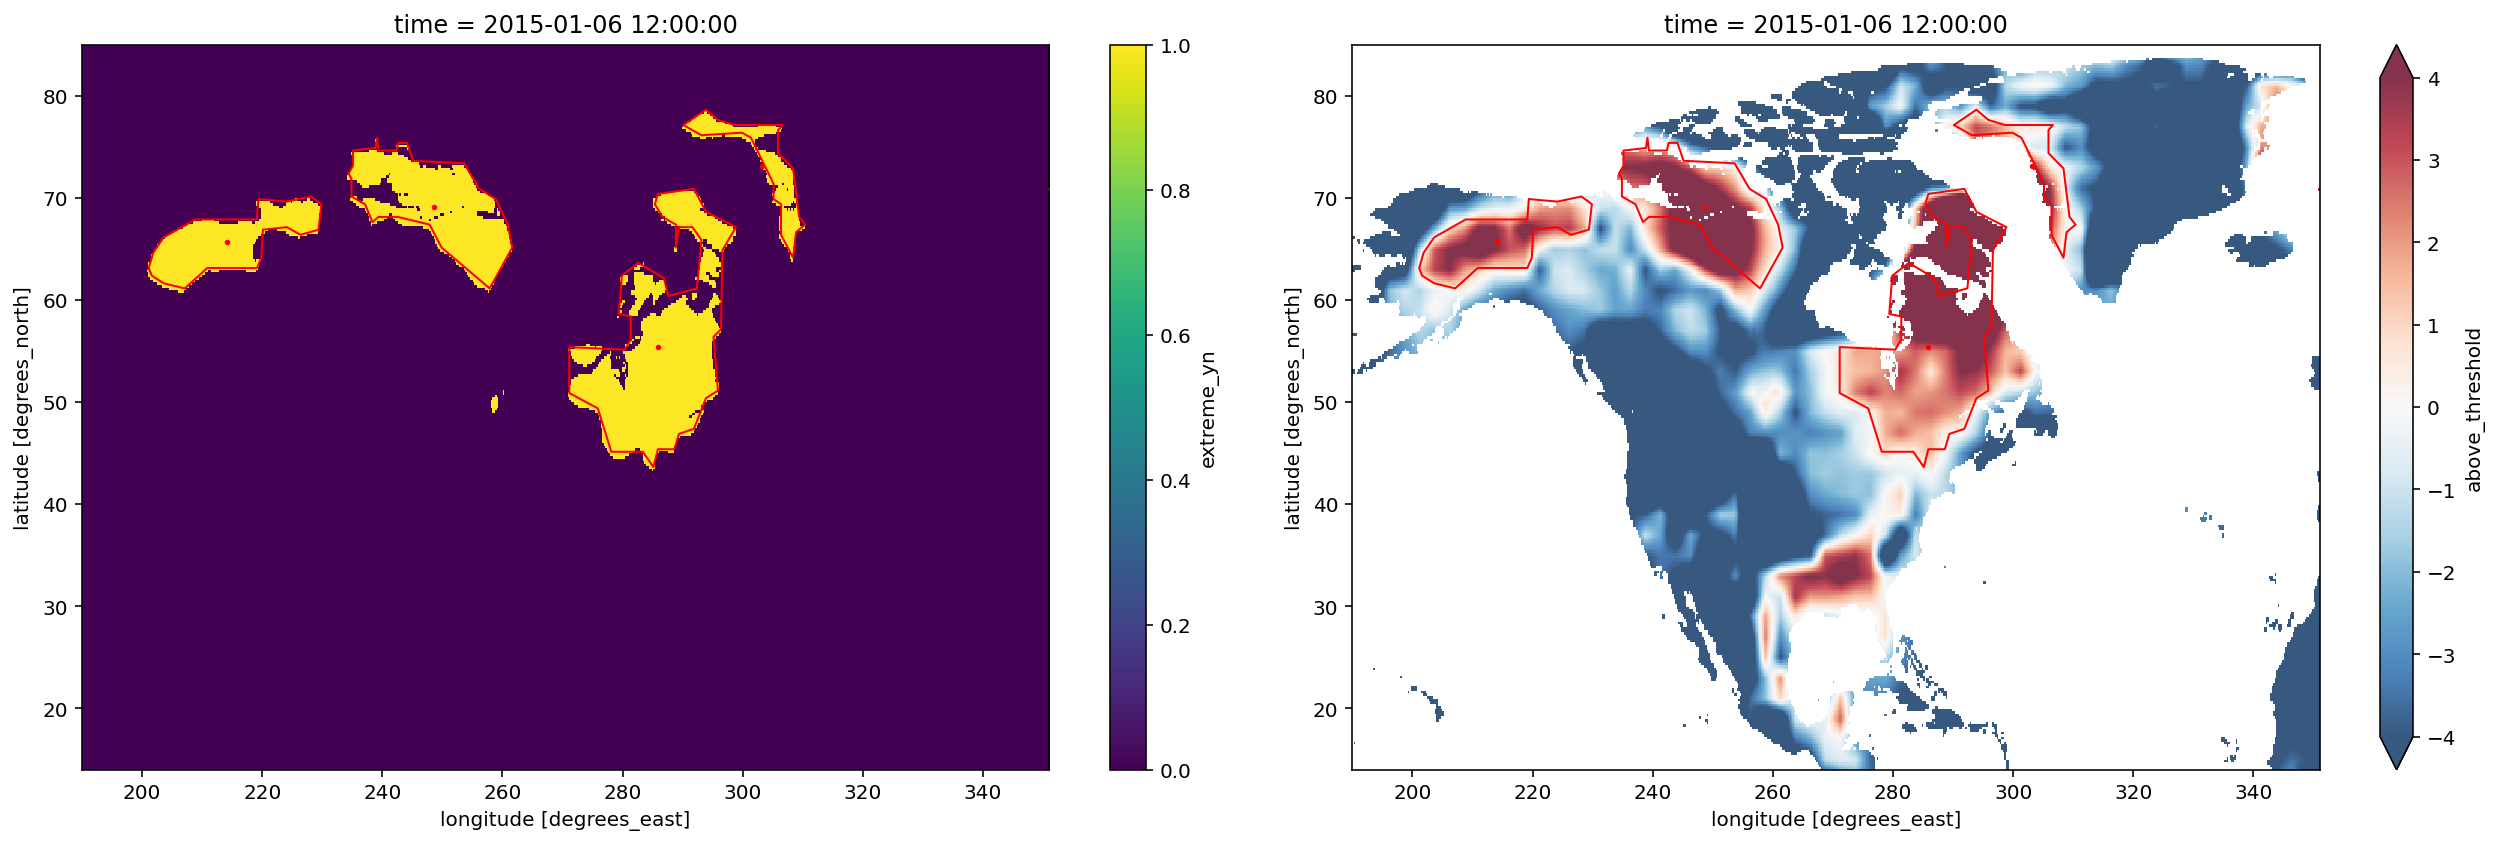

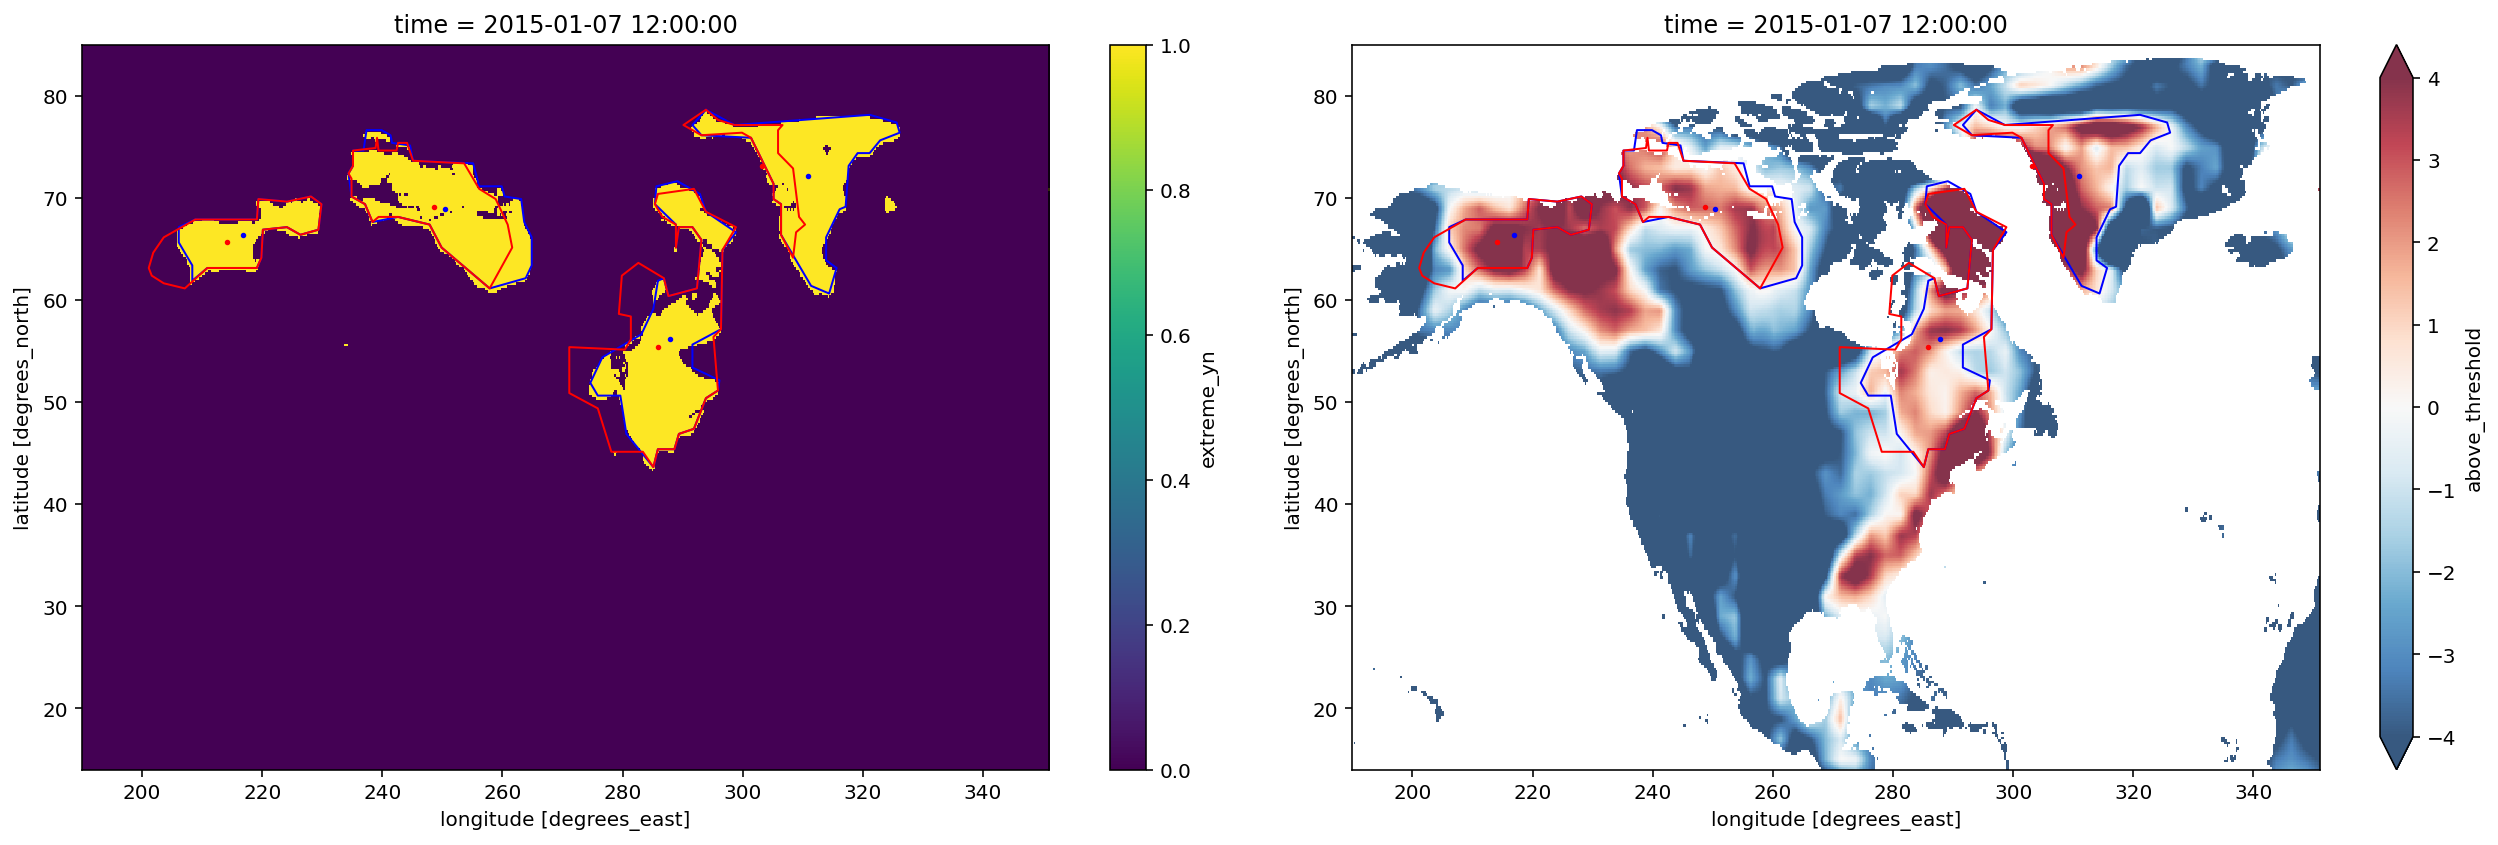

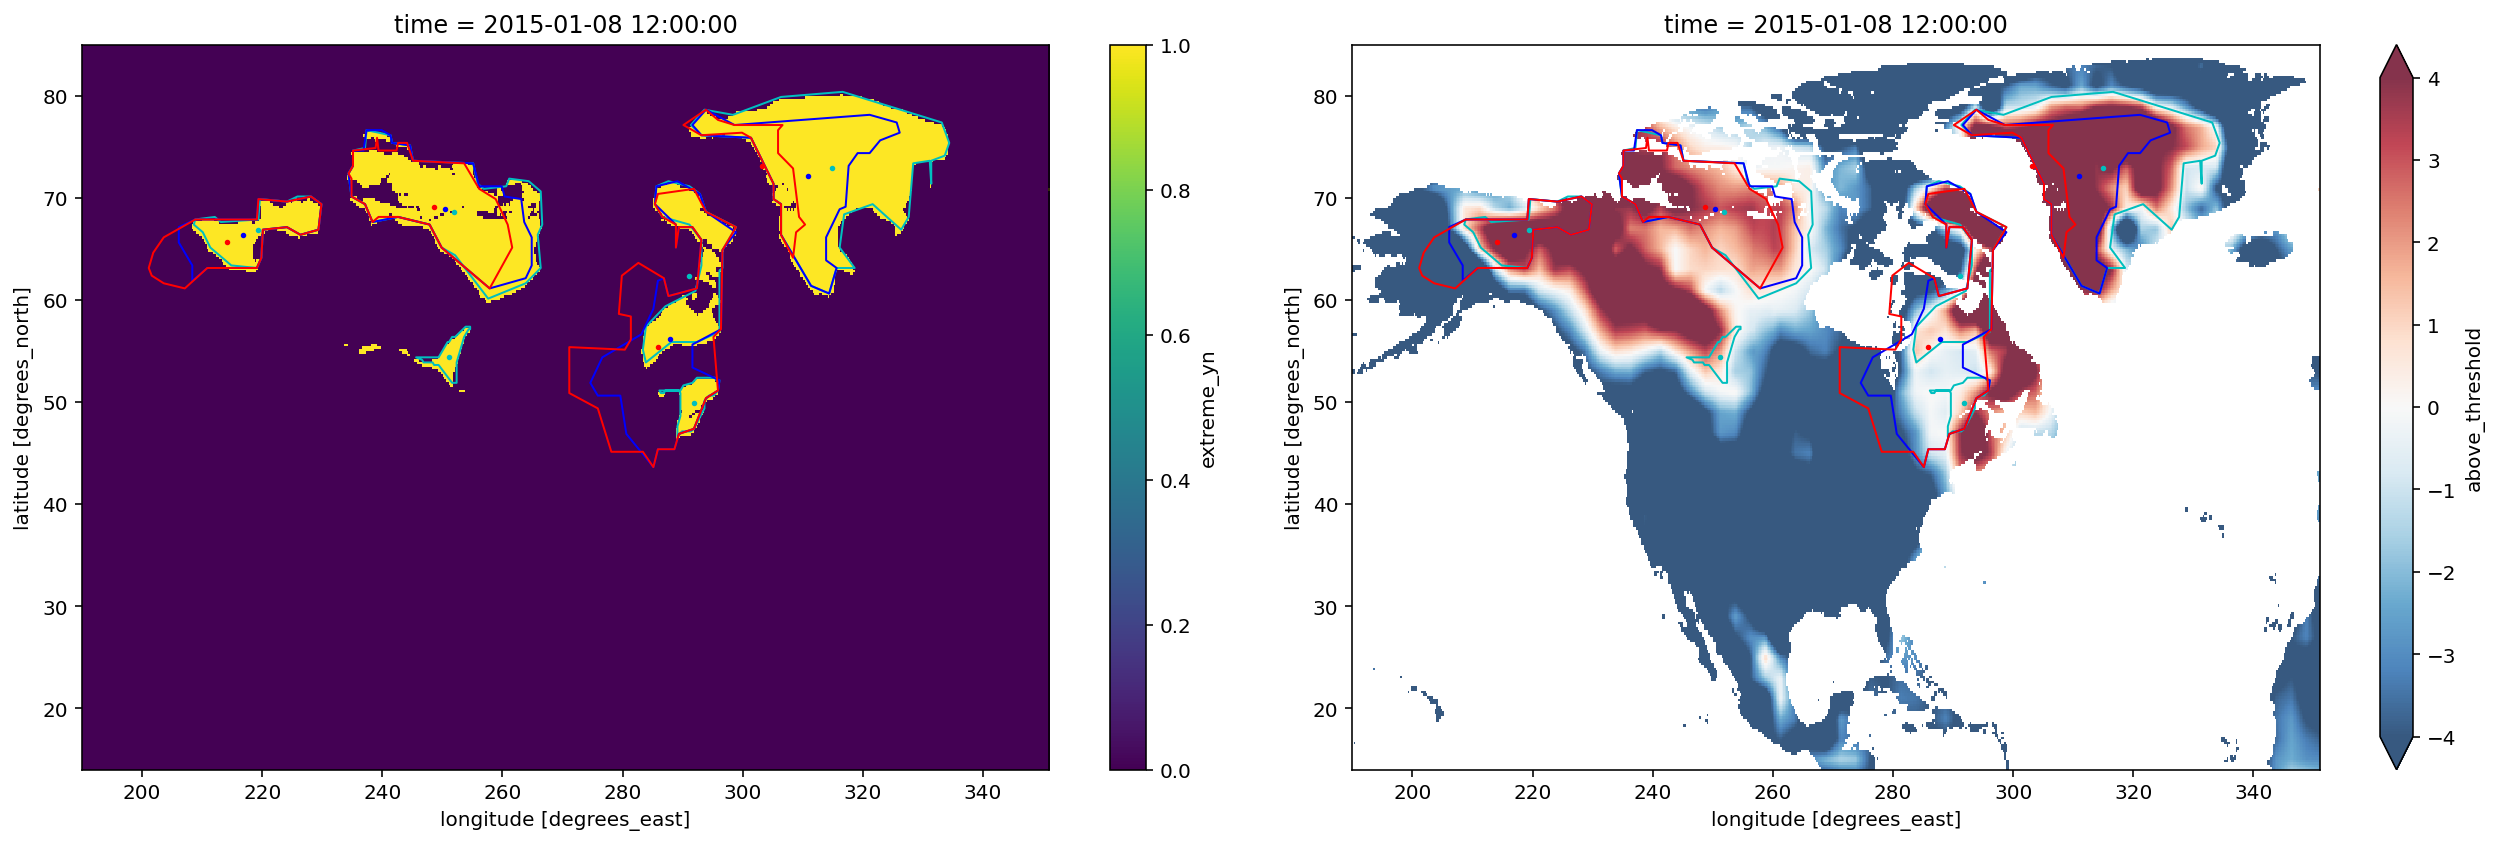

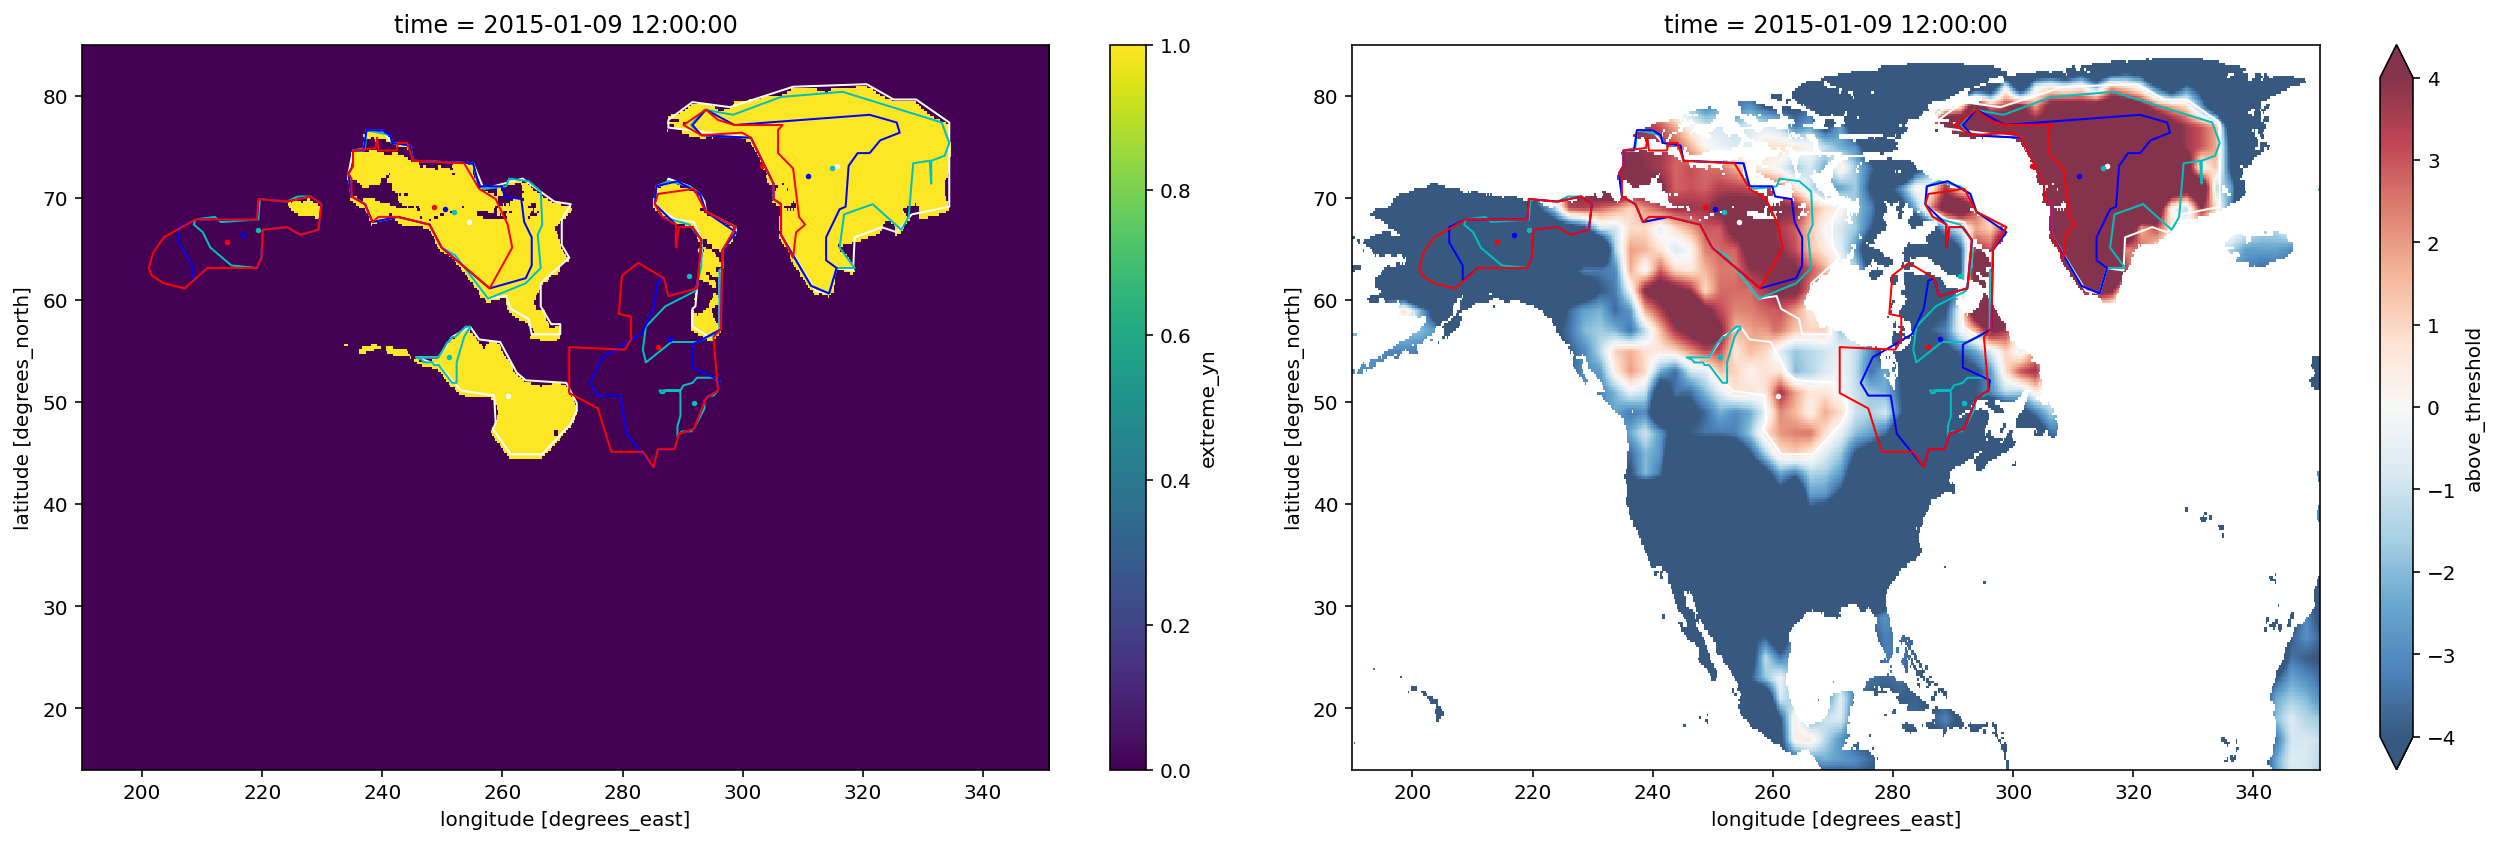

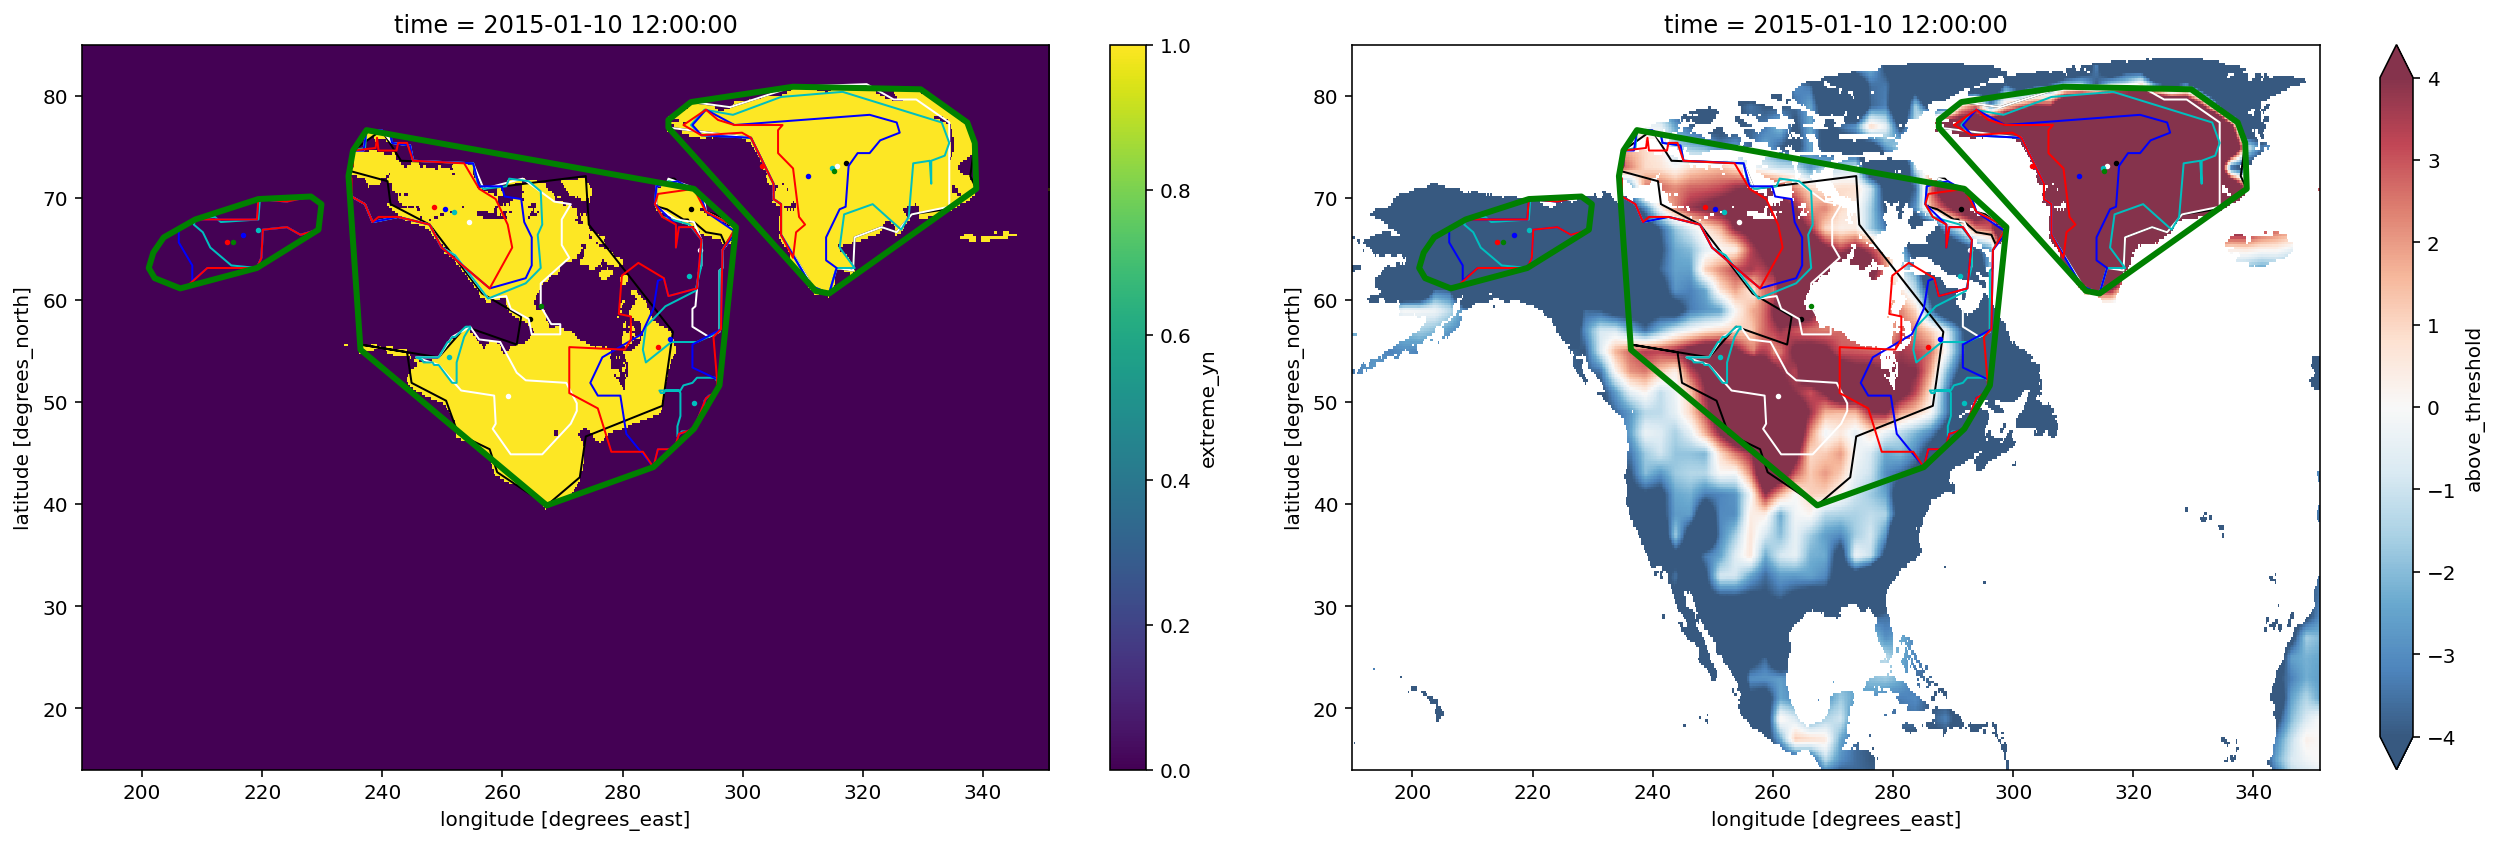

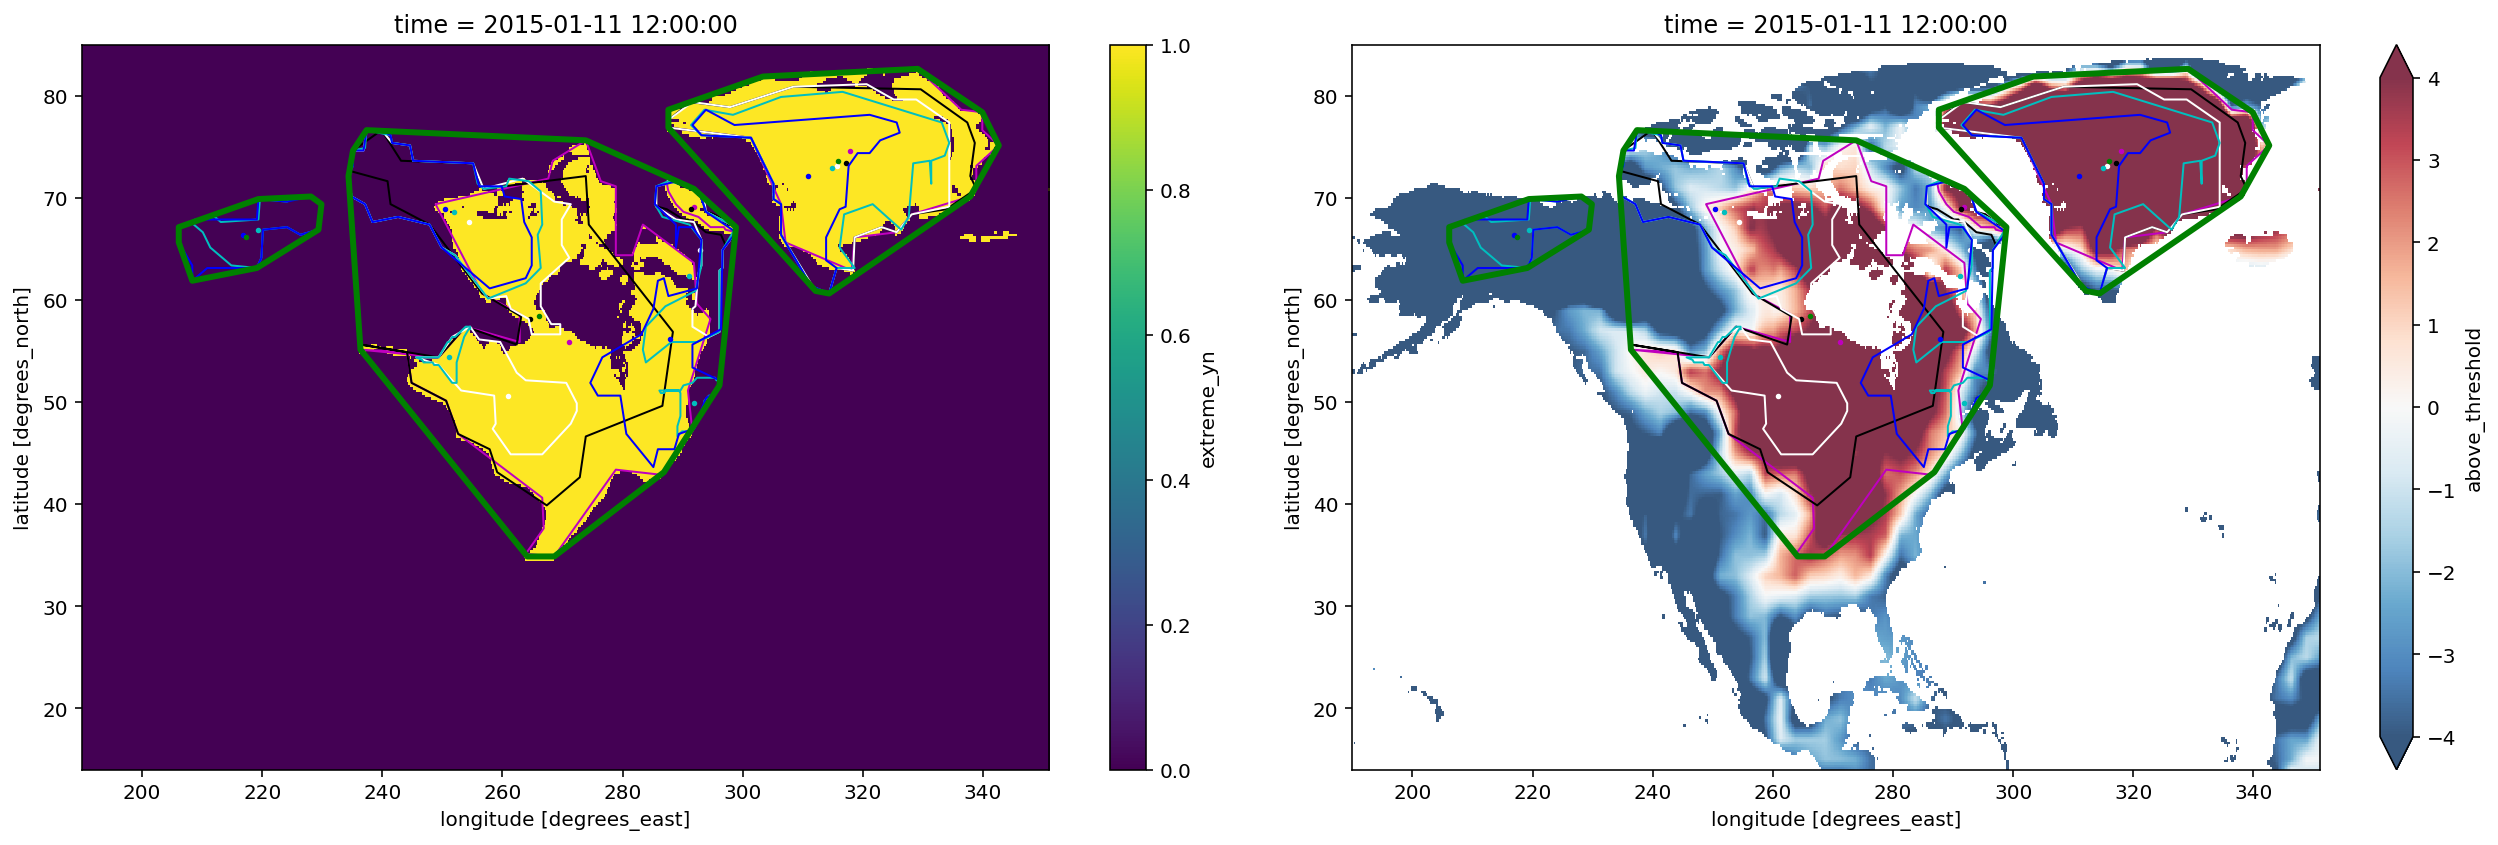

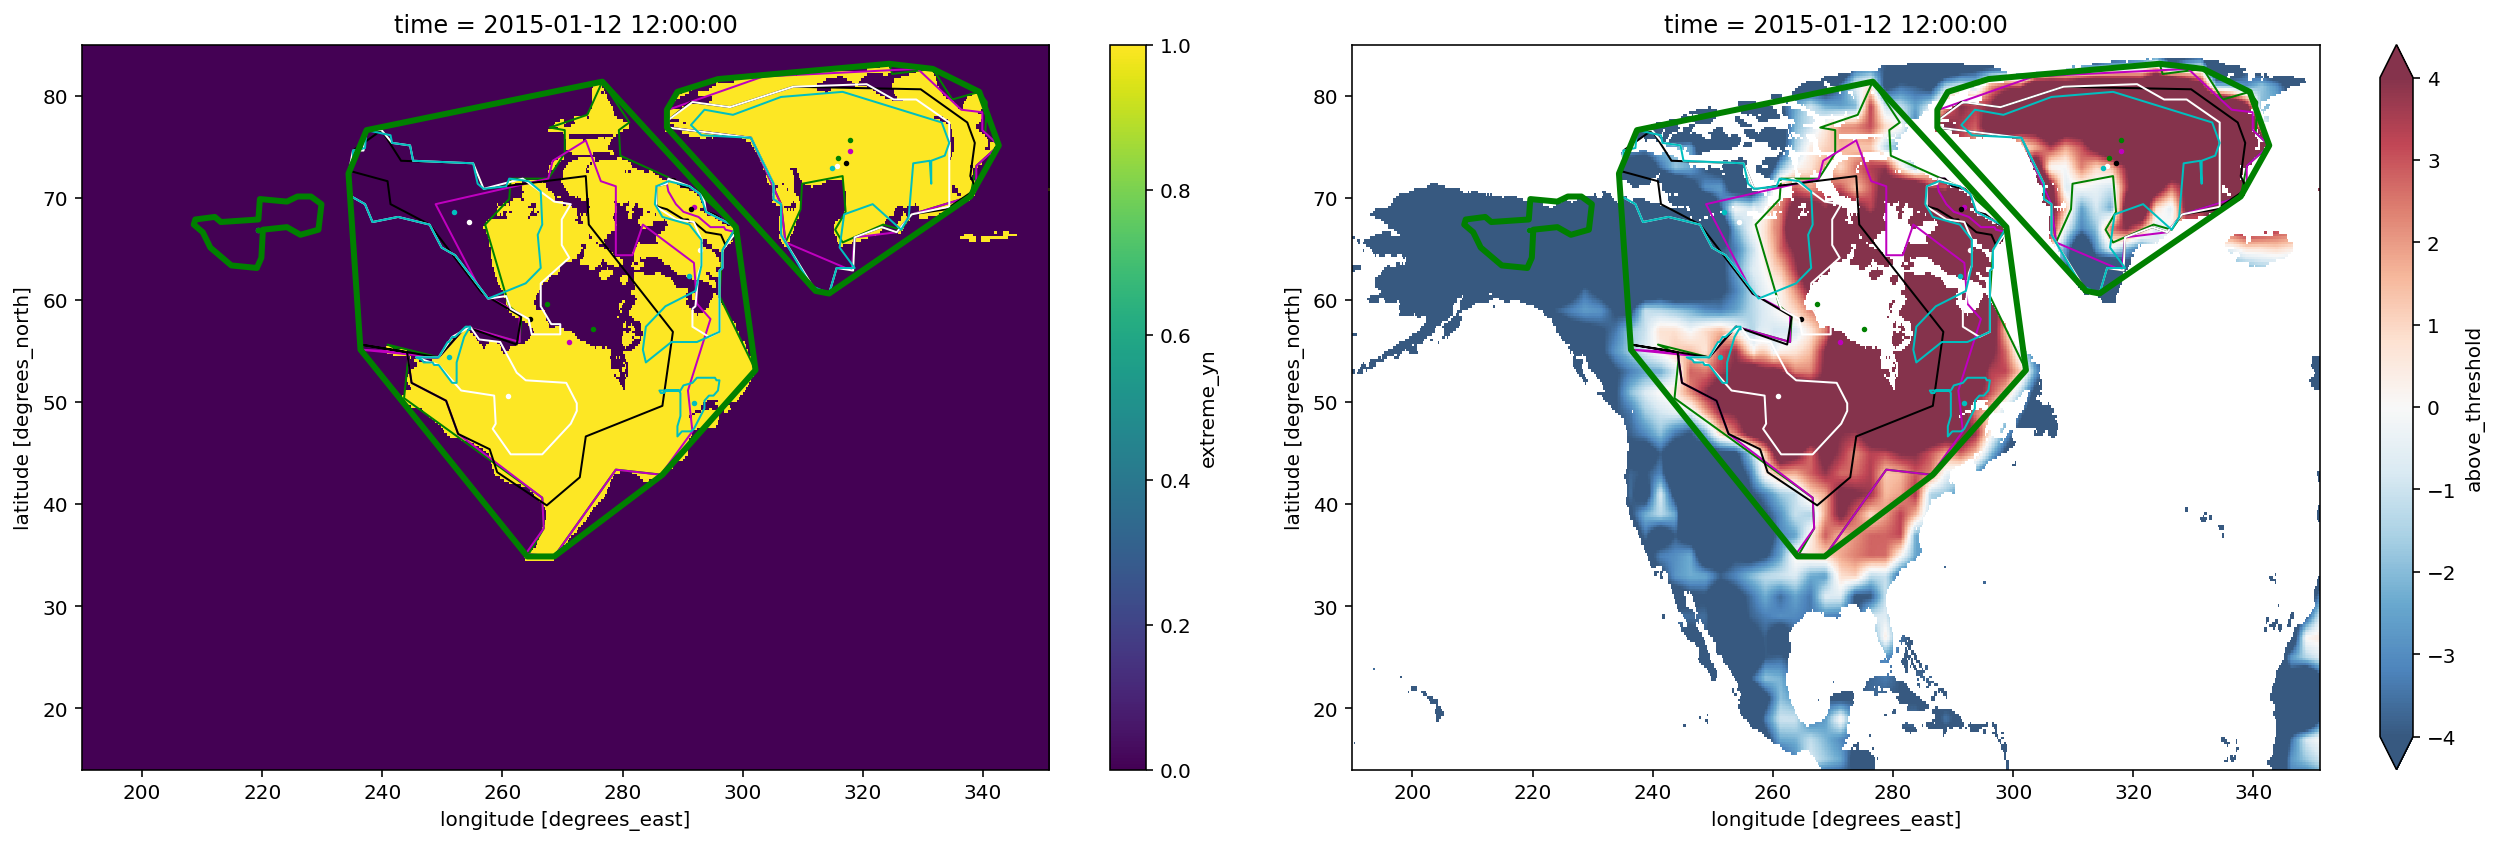

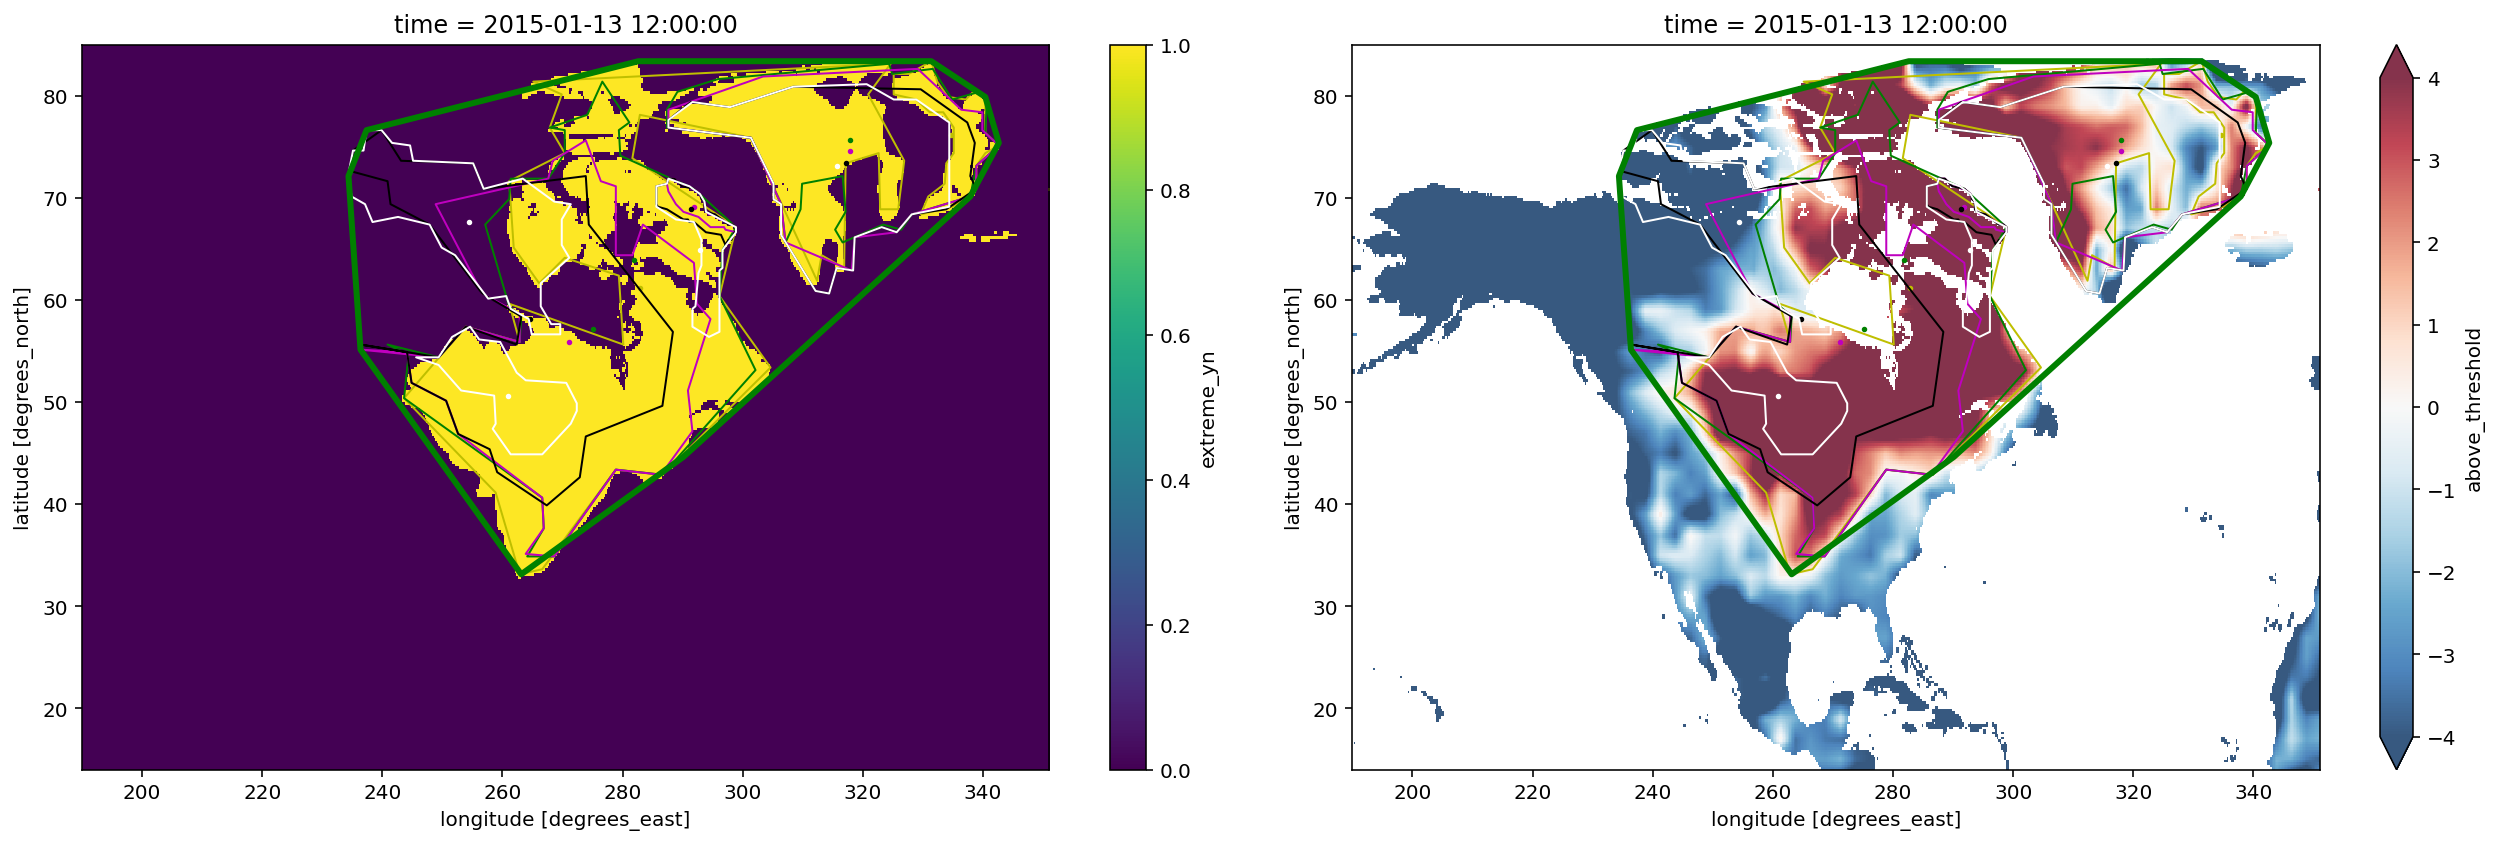

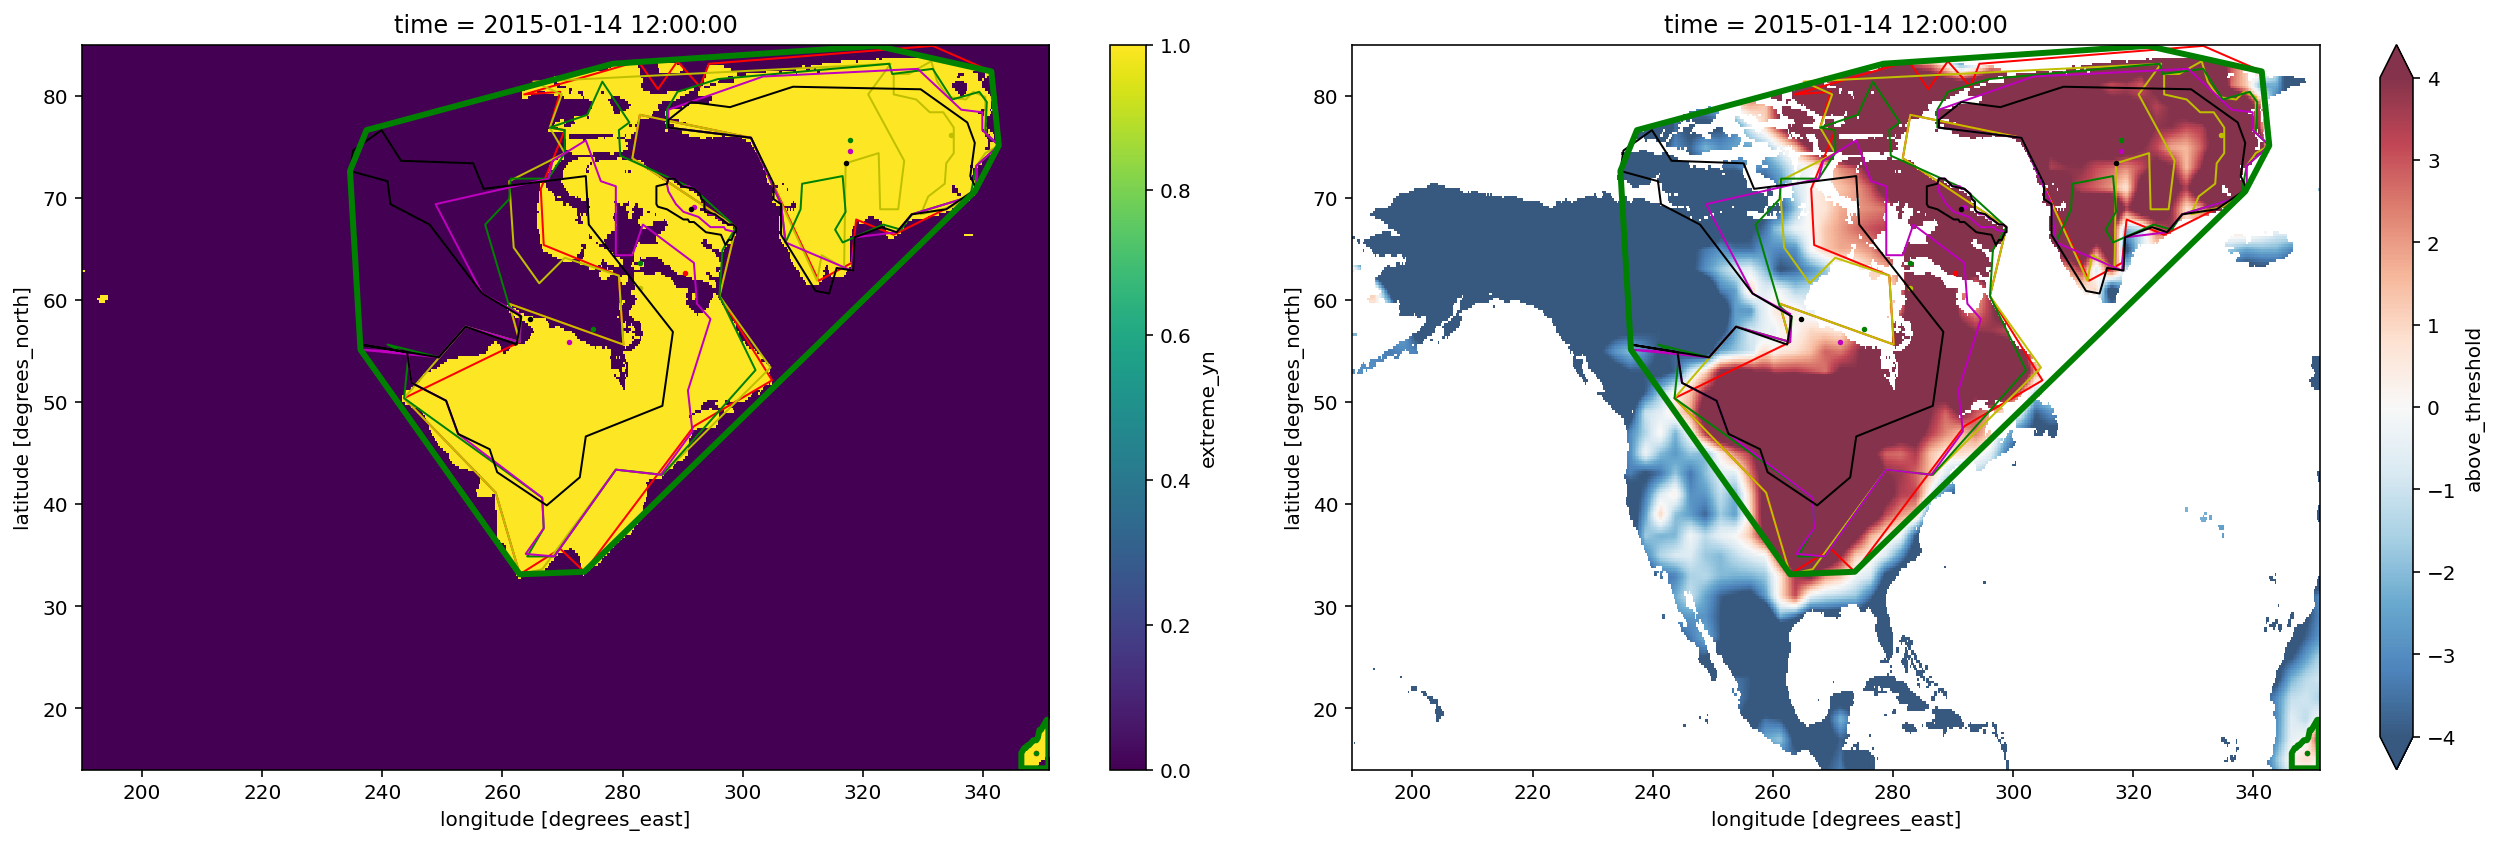

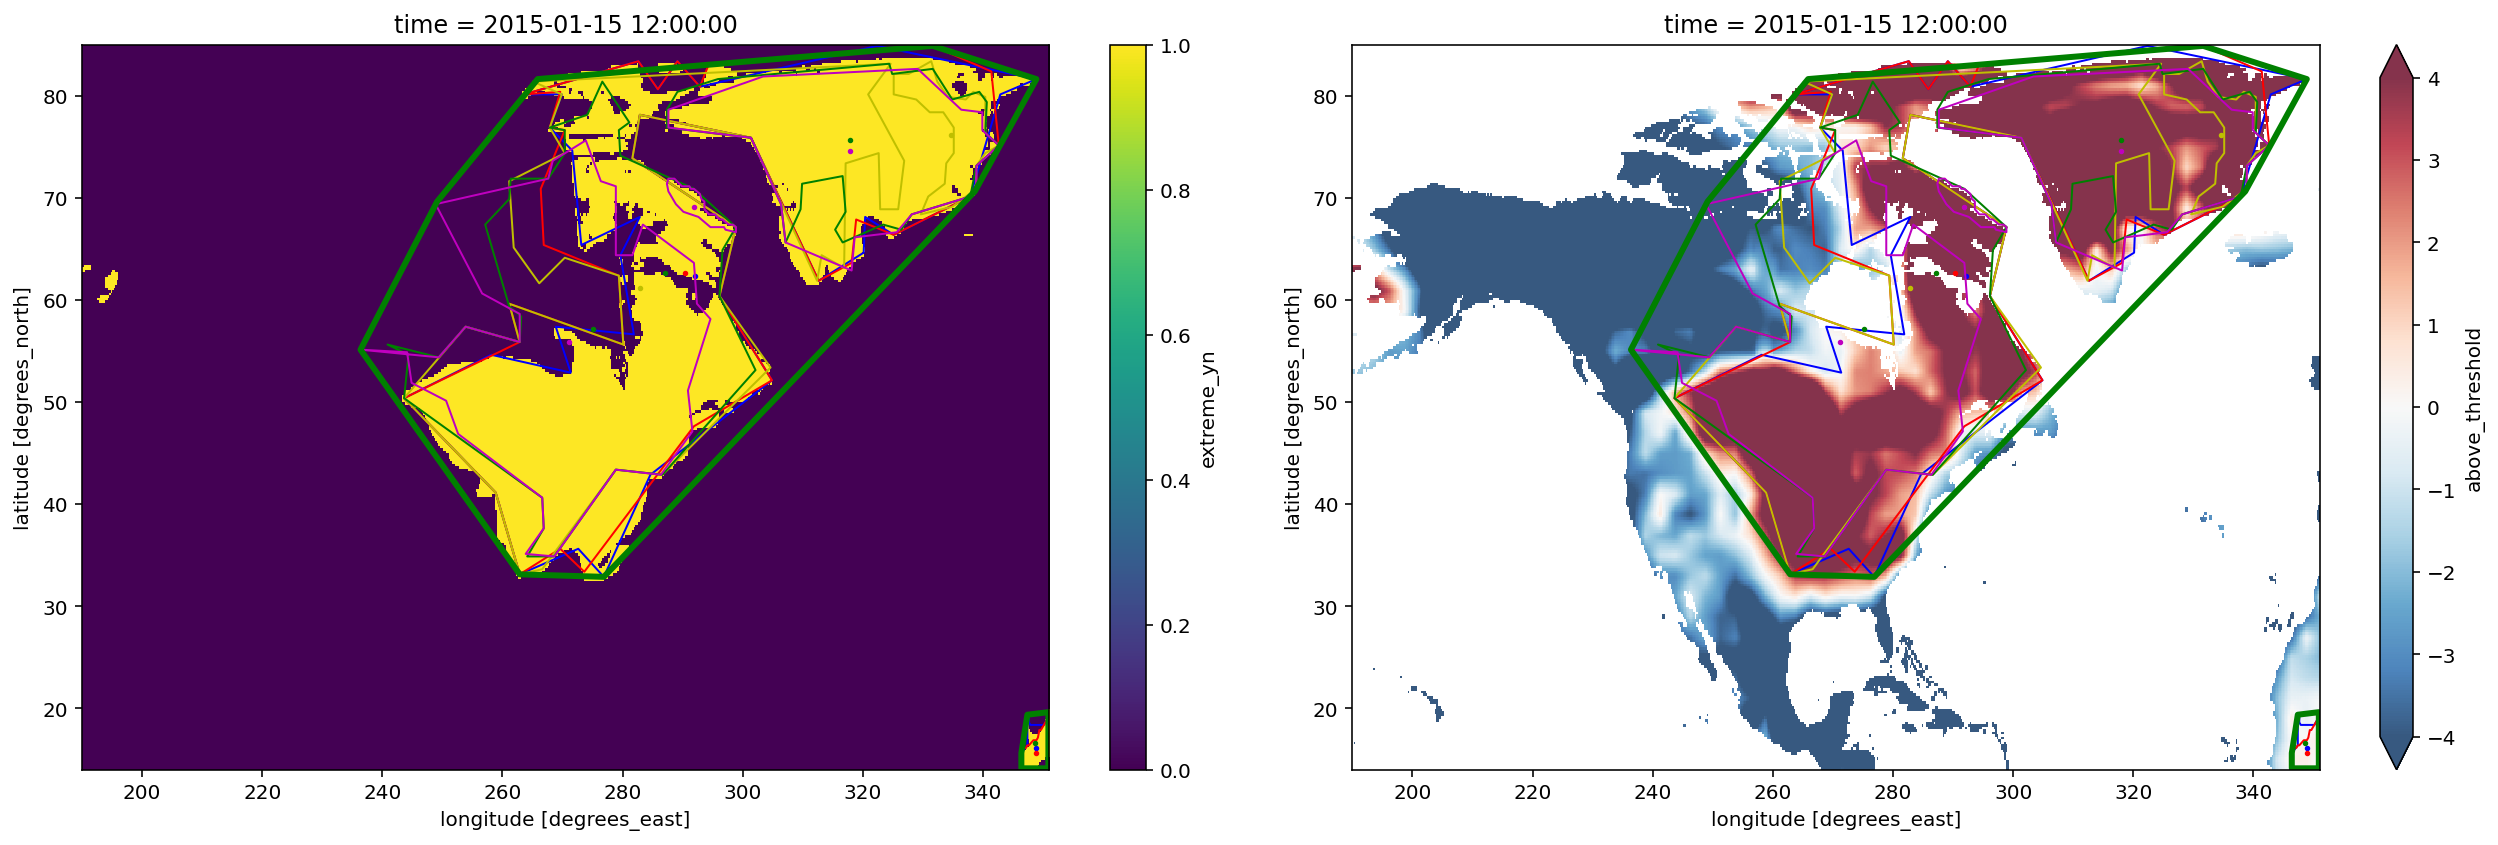

In [117]:
####################################
# Visualization pipeline
####################################

def plot_contours(ds:xr.Dataset, df:pd.DataFrame, i1:int, i2:int, window:int):  
    
    assert i1-window > 0
    
    def add_patches(key:str, _idx:int, color:str, linewidths:int):
        
        contours = df[key].iloc[_idx]
        patches = [Polygon(c.projected.squeeze(), True) for c in contours]

        args = dict(edgecolors=(color,), linewidths=(linewidths,), facecolor="none",)
        
        p = PatchCollection(patches, **args)
        ax1.add_collection(p)
        [ax1.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]

        p = PatchCollection(patches, **args)
        ax2.add_collection(p)
        [ax2.scatter(x=c.center[0], y=c.center[1], c=color, s=3) for c in contours]
    
    for i, idx in enumerate(range(i1, i2+1)):

        dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))
        day = dr[idx].strftime("%Y-%m-%d")
        tasmax = ds['tasmax'].sel(time=day)
        tdiff = ds['above_threshold'].sel(time=day)
        extreme = ds['extreme_yn'].sel(time=day)

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

        im1 = extreme.squeeze().plot.imshow(ax=ax1)
        im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

        colors = 'r b c w k m g y'.split()*10
        for x in range(i+1):
            add_patches('contours', idx-x, colors[i-x], 1)
            if x==window:
                add_patches('rolling_sum', idx, 'g', 3) 
                break

        fig.tight_layout()
        
plot_contours(ds, df_contours, 5, 14, window=ROLLING)

In [ ]:
# %%time
# def find_unique(contours: List[List[Contour]])->List[Contour]:
#     """Flattens list of lists of contours, then returns a list of uniques."""
    
#     flattened = reduce(lambda a,b: a+b, contours)
#     return list(Counter(flattened))

# def find_dates(c:Contour, df:pd.DataFrame)->pd.DataFrame:
#     """Get the subset of df for where a Contour object is in df['rolling_sum']. 
#     Then extract metadata of the input (continued) event `c`."""
#     df = df.copy()
    
#     sub = df[[c in cnts for cnts in df['rolling_sum'].dropna()]]
#     assert sub.index.is_monotonic # fail if uuid race-condition
    
#     i1 = sub['days'].index[0]
#     i2 = sub['days'].index[-1]
#     d1 = sub['days'].iloc[0]
#     d2 = sub['days'].iloc[-1]
#     tdelta = datetime.strptime(d2,'%Y-%m-%d') - datetime.strptime(d1,'%Y-%m-%d')
    
#     meta = [c, i1, i2, d1, d2, tdelta, c.area, c.center]

#     return meta

# unique_contours = find_unique(df_contours['rolling_sum'].dropna())

# df_x = pd.DataFrame(data=[find_dates(c, df_contours.dropna()) for c in unique_contours], 
#                   columns='contour i1 i2 start end duration area center'.split()) 

# df_x = df_x[df_x['duration'] > timedelta(days=1)].reset_index(drop=True)
# df_x